## 使用するPythonパッケージ

In [1]:
# もしinferactively-pymdpが環境に入ってなけれは#をとって以下を実行
#! pip install inferactively-pymdp

# 使用するパッケージ
# もし以下のパッケージが環境に入ってなければ、pip installでインストールする。
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import matplotlib.animation as animation
import pymdp
from pymdp import utils
from pymdp.agent import Agent
# シードの設定
np.random.seed(1234)

## プロットやグリッド（B行列）に関する自作関数

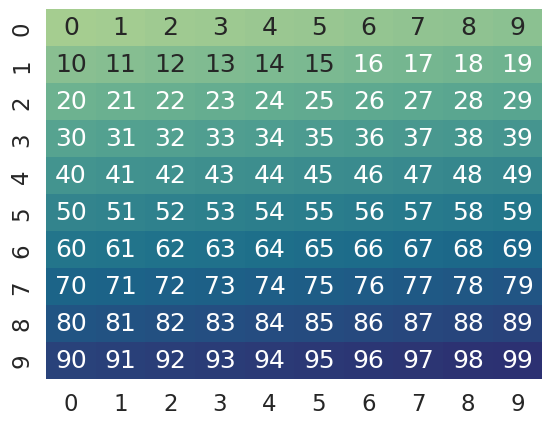

In [2]:
# グリッドの確認用関数
def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate
    labeled with its linear index (its `state id`)
    """
    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')
    plt.show()

# B行列の作成関数
def create_B_matrix():
  B = np.zeros( (len(grid_locations), len(grid_locations), len(actions)) )
  for action_id, action_label in enumerate(actions):
    for curr_state, grid_location in enumerate(grid_locations):
      y, x = grid_location
      if action_label == "UP":
        next_y = y - 1 if y > 0 else y
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 9 else y
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 9 else x
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[next_state, curr_state, action_id] = 1.0
  return B

# 行動サンプリング時に行動後の位置を取得する関数
def next_position(current_position,action_index,grid_size=(10,10)):
  possible_actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
  action_label = possible_actions[action_index]
  Y, X = current_position
  Y_new, X_new = Y, X
  if action_label == "UP":
    Y_new = Y - 1 if Y > 0 else Y
  elif action_label == "DOWN":
    Y_new = Y + 1 if Y < grid_size[0] - 1 else Y
  elif action_label == "LEFT":
    X_new = X - 1 if X > 0 else X
  elif action_label == "RIGHT":
    X_new = X + 1 if X < grid_size[1] - 1 else X
  elif action_label == "STAY":
    Y_new, X_new = Y, X
  new_positions = (Y_new, X_new)
  return new_positions

# グリッドの確認
grid_locations = list(itertools.product(range(10), repeat = 2))
plot_grid(grid_locations, num_x = 10, num_y = 10)

## 生成モデルの設定

In [3]:
# 状態やアクションの数などについて
n_m = 5 # モダリティの数(位置、上、下、左、右)
n_p = len(grid_locations) #位置の数
n_s = 3  # 周囲の状態の数(友好エージェント, 排斥エージェント, エージェントいない)
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
n_a = len(actions)

# Aの設定
A = utils.obj_array(n_m)
## Aの各モダリティは、観測、位置、上、下、左、右の６軸で設定する（観測はモダリティごとに変える）。
## 位置のモダリティ（状態と観測は一致）
A[0] = np.zeros((n_p, n_p, n_s, n_s, n_s, n_s))
for p in range(n_p):
    A[0][p, p, :, :, :, :] = 1.0
## 上のエージェントの状態（状態と観測は一致）
A[1] = np.zeros((n_s, n_p, n_s, n_s, n_s, n_s))
for s in range(n_s):
    A[1][s, :, s, :, :, :] = 1.0
## 下のエージェントの状態（状態と観測は一致）
A[2] = np.zeros((n_s, n_p, n_s, n_s, n_s, n_s))
for s in range(n_s):
    A[2][s, :, :, s, :, :] = 1.0
## 左のエージェントの状態（状態と観測は一致）
A[3] = np.zeros((n_s, n_p, n_s, n_s, n_s, n_s))
for s in range(n_s):
    A[3][s, :, :, :, s, :] = 1.0
## 右のエージェントの状態（状態と観測は一致）
A[4] = np.zeros((n_s, n_p, n_s, n_s, n_s, n_s))
for s in range(n_s):
    A[4][s, :, :, :, :, s] = 1.0

# Bの設定
B_pos = create_B_matrix()
# Stay時のB
stay_B = np.eye(n_s)
# 関心のエージェントと逆に移動した場合のB
opposite_B = np.array([
    [0, 0, 0],  # F → N
    [0, 0, 0],  # H → N
    [1, 1, 1],  # N → N
])
# Stayと逆に移動した場合以外は確率的に遷移するB
stochastic_B = np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4],
])
# 行動ごとの状態遷移の設定（UP）
B_UP = np.zeros((n_s, n_s, n_a))
B_UP[:, :, 0] = stochastic_B
B_UP[:, :, 1] = opposite_B
B_UP[:, :, 2] = stochastic_B
B_UP[:, :, 3] = stochastic_B
B_UP[:, :, 4] = stay_B
# 行動ごとの状態遷移の設定（DOWN）
B_DOWN = np.zeros((n_s, n_s, n_a))
B_DOWN[:, :, 0] = opposite_B
B_DOWN[:, :, 1] = stochastic_B
B_DOWN[:, :, 2] = stochastic_B
B_DOWN[:, :, 3] = stochastic_B
B_DOWN[:, :, 4] = stay_B
# 行動ごとの状態遷移の設定（LEFT）
B_LEFT = np.zeros((n_s, n_s, n_a))
B_LEFT[:, :, 0] = stochastic_B
B_LEFT[:, :, 1] = stochastic_B
B_LEFT[:, :, 2] = stochastic_B
B_LEFT[:, :, 3] = opposite_B
B_LEFT[:, :, 4] = stay_B
# 行動ごとの状態遷移の設定（RIGHT）
B_RIGHT = np.zeros((n_s, n_s, n_a))
B_RIGHT[:, :, 0] = stochastic_B
B_RIGHT[:, :, 1] = stochastic_B
B_RIGHT[:, :, 2] = opposite_B
B_RIGHT[:, :, 3] = stochastic_B
B_RIGHT[:, :, 4] = stay_B


B = utils.obj_array(n_m)
B[0] = B_pos
B[1] = B_UP
B[2] = B_DOWN
B[3] = B_LEFT
B[4] = B_RIGHT

# Cの設定
C_position = np.zeros(n_p)
C_direction = np.array([1.0, -1.0, -1.0])
C = utils.obj_array(n_m)
C[0] = C_position
C[1] = C_direction
C[2] = C_direction
C[3] = C_direction
C[4] = C_direction

# Dの設定
D_position = utils.onehot(0, n_p)
D_status = np.array([0.33, 0.33, 0.34])
D = utils.obj_array(n_m)
D[0] = D_position
D[1] = D_status
D[2] = D_status
D[3] = D_status
D[4] = D_status

## 環境クラスの設定

In [4]:
class GridWorldEnvMultiAgent:
    def __init__(self, num_agents, grid_size=(10, 10), initial_states=None, friendly_agents=None, hostile_agents=None):
        self.num_agents = num_agents
        
        self.grid_size = grid_size
        self.possible_actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

        self.agents_positions = []
        if initial_states is None:
            self.agents_positions = [self._get_random_position() for _ in range(num_agents)]
        elif isinstance(initial_states, list) and len(initial_states) == num_agents:
            for state in initial_states:
                if self._is_valid_position(state):
                    self.agents_positions.append(tuple(state))
                else:
                    raise ValueError(f"Initial state {state} is out of grid bounds.")
        else:
            raise ValueError("initial_states must be None or a list of initial states.")

        self.friendly_agents = friendly_agents if friendly_agents is not None else []
        self.hostile_agents = hostile_agents if hostile_agents is not None else []

    def _get_random_position(self):
        return (np.random.randint(self.grid_size[0]), np.random.randint(self.grid_size[1]))

    def _is_valid_position(self, position):
        return 0 <= position[0] < self.grid_size[0] and 0 <= position[1] < self.grid_size[1]

    def step(self, agent_index, action_label):
        if not (0 <= agent_index < self.num_agents):
            raise ValueError(f"Invalid agent index: {agent_index}")

        Y, X = self.agents_positions[agent_index]
        if action_label == "UP":
            Y = max(Y - 1, 0)
        elif action_label == "DOWN":
            Y = min(Y + 1, self.grid_size[0] - 1)
        elif action_label == "LEFT":
            X = max(X - 1, 0)
        elif action_label == "RIGHT":
            X = min(X + 1, self.grid_size[1] - 1)
        elif action_label == "STAY":
            pass

        new_position = (Y, X)
        self.agents_positions[agent_index] = new_position
        return new_position

    def reset(self, initial_states=None):
        if initial_states and len(initial_states) == self.num_agents:
            self.agents_positions = [tuple(state) for state in initial_states]
        else:
            self.agents_positions = [self._get_random_position() for _ in range(self.num_agents)]

    def determine_direction_status(self, agent_index, direction):
        """
        指定方向（UP, DOWN, LEFT, RIGHT）にいるエージェントの状態を返す
        0: 友好, 1: 排斥, 2: なし
        """
        Y, X = self.agents_positions[agent_index]
        if direction == "UP":
            pos = (Y - 1, X)
        elif direction == "DOWN":
            pos = (Y + 1, X)
        elif direction == "LEFT":
            pos = (Y, X - 1)
        elif direction == "RIGHT":
            pos = (Y, X + 1)
        else:
            raise ValueError(f"Invalid direction: {direction}")

        if not self._is_valid_position(pos):
            return 2  # outside grid = none

        friendly_positions = {self.agents_positions[i] for i in self.friendly_agents if i != agent_index}
        hostile_positions = {self.agents_positions[i] for i in self.hostile_agents if i != agent_index}

        if pos in friendly_positions:
            return 0
        elif pos in hostile_positions:
            return 1
        else:
            return 2

    def get_position_obs(self, agent_index):
        """位置の線形インデックスを返す"""
        Y, X = self.agents_positions[agent_index]
        return Y * self.grid_size[1] + X
    def int2onehot(idx: int, n_outcomes: int):
        vec = np.zeros(n_outcomes)
        vec[idx] = 1.0
        return vec

    def get_obs(self, agent_index):
        """
        能動的推論モデルに入力する観測ベクトル [位置, 上, 下, 左, 右] を返す
        """
        pos_idx   = self.get_position_obs(agent_index)                    
        up_idx    = self.determine_direction_status(agent_index, "UP")    
        down_idx  = self.determine_direction_status(agent_index, "DOWN")
        left_idx  = self.determine_direction_status(agent_index, "LEFT")
        right_idx = self.determine_direction_status(agent_index, "RIGHT")

        obs_position = utils.onehot(pos_idx,   n_p).astype(int)
        obs_up       = utils.onehot(up_idx,    n_s).astype(int)
        obs_down     = utils.onehot(down_idx,  n_s).astype(int)
        obs_left     = utils.onehot(left_idx,  n_s).astype(int)
        obs_right    = utils.onehot(right_idx, n_s).astype(int)
        return [obs_position, obs_up, obs_down, obs_left, obs_right]

    def get_agents_positions(self):
        return self.agents_positions

## シミュレーションの実行

このシミュレーションは実行に時間がかかります（国里の環境では38時間かかっています）。

In [5]:
%%time
# シミュレーションの設定
num_agents   = 16
friendly     = list(range(0, 12))   #友好エージェント
hostile      = list(range(12, 16))  #排斥エージェント
n_steps      = 50
actions      = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
# 環境のインスタンス化
env = GridWorldEnvMultiAgent(
    num_agents       = num_agents,
    grid_size        = (10, 10),
    friendly_agents  = friendly,
    hostile_agents   = hostile
)
# エージェントのインスタンス化
agents = [Agent(A=A, B=B, C=C, D=D,
                  inference_algo='MMP',
                  policy_len=1, inference_horizon=2,
                  sampling_mode='full',
                  action_selection='stochastic')] * num_agents
# 初期観測（位置+上下左右の友好/敵対/なし）
obs_list = [env.get_obs(i) for i in range(num_agents)]
data = []
# シミュレーションの実行
for t in range(n_steps):
    for i in range(num_agents):
        # 状態推論、方策推論
        agents[i].infer_states(obs_list[i])
        agents[i].infer_policies()
        # 行動は一回サンプリングするが、衝突したらSTAYにする
        current_pos = env.agents_positions[i]
        a_idx   = int(agents[i].sample_action()[0])
        a_label = actions[a_idx] 
        next_pos = next_position(current_pos, a_idx, grid_size=env.grid_size)
        # STAY以外のアクションで他エージェントと衝突したらSTAYに差し替え
        if a_idx < 4:
            if obs_list[i][a_idx + 1][2] != 1:
                a_idx   = 4
                a_label = actions[a_idx]
                next_pos = current_pos
        # 周囲にいる人の情報を得る
        log_up = np.where(obs_list[i][1] == 1)[0][0] + 1
        log_down = np.where(obs_list[i][2] == 1)[0][0] + 1
        log_left = np.where(obs_list[i][3] == 1)[0][0] + 1
        log_right = np.where(obs_list[i][4] == 1)[0][0] + 1
        # 環境を 1 ステップ進める
        env.step(i, a_label)
        # ログ
        log_row = {
            "position" : current_pos,
            "agent_id"  : i+1,
            "time"      : t+1,
            "action"    : a_label,
            "next_position"  : next_pos,
            "up" : log_up,
            "down" : log_down,
            "left":log_left,
            "right":log_right
        }
        print(log_row)
        data.append(log_row)
    # 全エージェントが動いた後に観測を更新
    obs_list = [env.get_obs(k) for k in range(num_agents)]

{'position': (3, 6), 'agent_id': 1, 'time': 1, 'action': 'UP', 'next_position': (2, 6), 'up': np.int64(3), 'down': np.int64(3), 'left': np.int64(3), 'right': np.int64(3)}
{'position': (5, 4), 'agent_id': 2, 'time': 1, 'action': 'UP', 'next_position': (4, 4), 'up': np.int64(3), 'down': np.int64(3), 'left': np.int64(3), 'right': np.int64(3)}
{'position': (8, 9), 'agent_id': 3, 'time': 1, 'action': 'STAY', 'next_position': (8, 9), 'up': np.int64(3), 'down': np.int64(3), 'left': np.int64(3), 'right': np.int64(3)}
{'position': (1, 7), 'agent_id': 4, 'time': 1, 'action': 'LEFT', 'next_position': (1, 6), 'up': np.int64(3), 'down': np.int64(3), 'left': np.int64(3), 'right': np.int64(3)}
{'position': (9, 6), 'agent_id': 5, 'time': 1, 'action': 'STAY', 'next_position': (9, 6), 'up': np.int64(3), 'down': np.int64(3), 'left': np.int64(3), 'right': np.int64(3)}
{'position': (8, 0), 'agent_id': 6, 'time': 1, 'action': 'STAY', 'next_position': (8, 0), 'up': np.int64(1), 'down': np.int64(2), 'left': n

## シミュレーションの可視化と保存

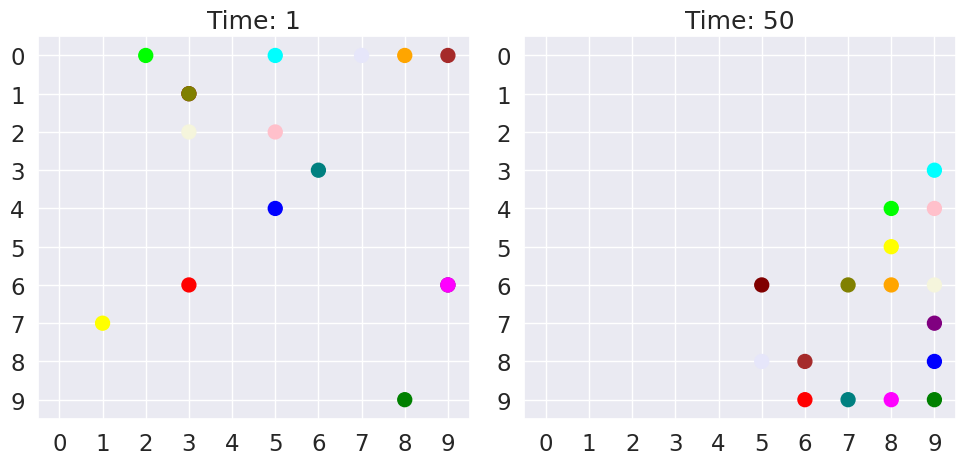

In [6]:
df = pd.DataFrame(data)
# X座標とY座標を抽出
df['X'] = df['position'].apply(lambda xy: xy[0])
df['Y'] = df['position'].apply(lambda xy: xy[1])
# IDのリストを取得して、色分けに利用
unique_ids = df['agent_id'].unique()
pattern = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta',
           'lime', 'pink', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'olive']
color_map = {id_: pattern[i] for i, id_ in enumerate(unique_ids)}

# アニメーションの準備
fig, ax = plt.subplots()
scat = ax.scatter([], [], animated=True, s=100)
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.invert_yaxis()
ax.set_title("Movement of Agents over Time")
# XY軸の目盛りを1単位に設定
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
# グリッドを表示
ax.grid(True)
# 各時点のデータを準備
grouped_by_timestep = df.groupby('time')
timesteps = sorted(grouped_by_timestep.groups.keys())
data_for_animation = [grouped_by_timestep.get_group(t) for t in timesteps]
def update(frame):
    current_df = data_for_animation[frame]
    x_coords = current_df['X'].values
    y_coords = current_df['Y'].values
    id_colors = [color_map[id_] for id_ in current_df['agent_id']]
    scat.set_offsets(np.c_[x_coords, y_coords])
    scat.set_facecolors(id_colors)
    return (scat,)

# アニメーションの作成
anim = animation.FuncAnimation(fig, update, frames=len(data_for_animation), interval=1000, blit=True)
html_animation = HTML(anim.to_html5_video())
display(html_animation)
anim.save('agent_movement01.mp4', writer='ffmpeg')
plt.close()

# 最初と最後の画像をsubplotで表示
fig_static, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
## 最初の時点のデータを描画
first_df = data_for_animation[0]
x_first = first_df['X'].values
y_first = first_df['Y'].values
colors_first = [color_map[id_] for id_ in first_df['agent_id']]
ax1.scatter(x_first, y_first, c=colors_first, s=100)
ax1.set_xlim(-0.5, 9.5)
ax1.set_ylim(-0.5, 9.5)
ax1.invert_yaxis()
ax1.set_title(f"Time: {timesteps[0]}")
ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_yticks(np.arange(0, 10, 1))
ax1.grid(True)
## 最後の時点のデータを描画
last_df = data_for_animation[-1]
x_last = last_df['X'].values
y_last = last_df['Y'].values
colors_last = [color_map[id_] for id_ in last_df['agent_id']]
ax2.scatter(x_last, y_last, c=colors_last, s=100)
ax2.set_xlim(-0.5, 9.5)
ax2.set_ylim(-0.5, 9.5)
ax2.invert_yaxis()
ax2.set_title(f"Time: {timesteps[-1]}")
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_yticks(np.arange(0, 10, 1))
ax2.grid(True)
plt.tight_layout()
plt.savefig('agent_movement.png')
plt.show()
plt.close()

## グレースケールで可視化

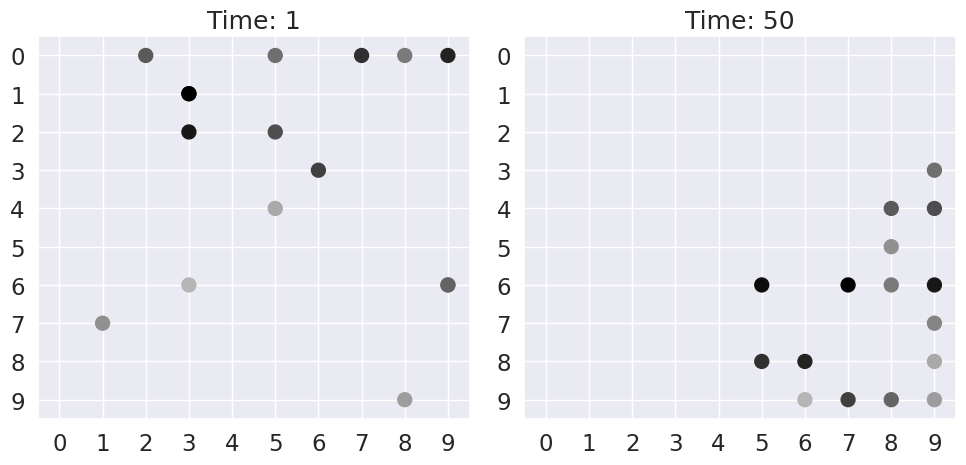

In [7]:
from matplotlib.colors import to_hex
greys = plt.cm.Greys(np.linspace(0.4, 1.0, 16))
greys_hex = [to_hex(c) for c in greys]
color_map = {id_: greys_hex[i] for i, id_ in enumerate(unique_ids)}
# 最初と最後の画像をsubplotで表示
fig_static, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
## 最初の時点のデータを描画
first_df = data_for_animation[0]
x_first = first_df['X'].values
y_first = first_df['Y'].values
colors_first = [color_map[id_] for id_ in first_df['agent_id']]
ax1.scatter(x_first, y_first, c=colors_first, s=100)
ax1.set_xlim(-0.5, 9.5)
ax1.set_ylim(-0.5, 9.5)
ax1.invert_yaxis()
ax1.set_title(f"Time: {timesteps[0]}")
ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_yticks(np.arange(0, 10, 1))
ax1.grid(True)
## 最後の時点のデータを描画
last_df = data_for_animation[-1]
x_last = last_df['X'].values
y_last = last_df['Y'].values
colors_last = [color_map[id_] for id_ in last_df['agent_id']]
ax2.scatter(x_last, y_last, c=colors_last, s=100)
ax2.set_xlim(-0.5, 9.5)
ax2.set_ylim(-0.5, 9.5)
ax2.invert_yaxis()
ax2.set_title(f"Time: {timesteps[-1]}")
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_yticks(np.arange(0, 10, 1))
ax2.grid(True)
plt.tight_layout()
plt.savefig('agent_movement.png')
plt.show()
plt.close()